# Import libraries

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib
# import plotly.plotly as py
# import plotly.graph_objs as go
import time
import seaborn as sns


pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format

In [93]:
start_time = time.time()

# From txt to csv

In [94]:
# #from txt file
# df = pd.read_csv('Propwall_Report_ForRent.txt', sep = '\t')
# #save to csv
# df.to_csv("Propwall_Report_ForRent.csv",index = False,encoding='utf-8')

# UDF

In [5]:
#remove outliers
def remove_Outlier_box(values):
    firstq,median,thirdq = values.dropna().quantile([0.25,0.5,0.75])
    IQR = thirdq - firstq
    return ~(((values-thirdq)>1.5*IQR) | ((firstq-values)>1.5*IQR))

In [3]:
def extractPostcodeState(loc_array):
    result_arr = np.array([])
    for x in loc_array:
        loc = str(x).split(',')
        df_result = df_dict[(df_dict['area'] == loc[0].lstrip()) | (df_dict['city'] == loc[0].lstrip())]
#         df_result = df_dict[levenshtein_dist(df_dict['area'], loc[1].lstrip())]
        if len(df_result):
            result_arr = np.append(arr=result_arr ,values=(df_result.state_code.unique()[0]))
        else:
            result_arr = np.append(arr=result_arr ,values=np.nan)
#         print (df_result.state_code.unique()[0])
    return (result_arr)

In [4]:
def extractStateCode(loc_array):
    result_arr = np.array([str(x).split(',')[-1].lstrip() for x in loc_array])
#     print (result_arr)
    result_arr = list(map(lambda x: state_code_dict[to_state_dict[x]] if x in to_state_dict else np.nan, result_arr))
#     print (result_arr)
    return (result_arr)

In [37]:
def mad_outliers(points, thr = 1):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis = 0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    
    #greater than threshold is outliers, recommended by Iglewicz and Hoaglin 
    return modified_z_score<thr

# Dict

In [6]:
state_code_dict = {
    'PLS':'Perlis',
    'KDH':'Kedah',
    'PNG':'Penang',
    'KTN':'Kelantan',
    'TRG':'Terengganu',
    'PHG':'Pahang',
    'SGR':'Selangor',
    'PRK':'Perak',
    'KUL':'Kuala Lumpur',
    'KL' : 'Kuala Lumpur',
    'PJY' : 'Petaling Jaya',
    'NSN' : 'Negeri Sembilan',
    'MLK' : 'Melaka',
    'JHR':'Johor',
    'LBN':'Labuan',
    'SBH':'Sabah',
    'SRW':'Sarawak',
}

#get state
state_dict = {'Perlis':'PLS','Kedah':'KDH','Penang':'PNG','Kelantan':'KTN',
'Terengganu':'TRG','Pahang':'PHG','Selangor':'SGR','Perak':'PRK','Kuala Lumpur':'KUL','KL':'KUL',
'Petaling Jaya':'PJY','Negeri Sembilan':'NSN', 'Melaka':'MLK',
'Johor':'JHR','Labuan':'LBN','Sabah':'SBH','Sarawak':'SRW'}

#get city
city_dict = {
'KLCC' : 'Kuala Lumpur',
'KL City Centre' : 'Kuala Lumpur',
'Dutamas' : 'Kuala Lumpur',
'Selayang' : 'Kuala Lumpur',
'Melawati' : 'Kuala Lumpur',
'Kota Damansara': 'Selangor',
'Cheras South' : 'Selangor',
'Seberang Perai' : 'Penang',
'Brickfields' : 'Kuala Lumpur',
'Old Klang Road' : 'Kuala Lumpur',
'Tropicana' : 'Selangor',
'Bandar Sri Damansara' : 'Kuala Lumpur',
'TTDI' : 'Kuala Lumpur',
'Sri Petaling' : 'Kuala Lumpur',
'Ampang Hilir' : 'Kuala Lumpur',
'Sentul' : 'Kuala Lumpur',
'Wangsa Maju' : 'Kuala Lumpur',
'Setiawangsa' : 'Kuala Lumpur',
'Georgetown' : 'Penang',
'Ukay' : 'Kuala Lumpur',
'Bangsar' : 'Kuala Lumpur',
'Segambut' : 'Kuala Lumpur',
'Pudu' : 'Kuala Lumpur',
'Bukit Bintang' : 'Kuala Lumpur',
'UEP Subang Jaya' : 'Selangor',
'Port Klang' : 'Selangor',
'Seputeh' : 'Kuala Lumpur',
'Damansara Heights' : 'Kuala Lumpur',
'Bukit Tunku' : 'Kuala Lumpur',
'Mid Valley City' : 'Kuala Lumpur',
'Subang' : 'Selangor',
'Meru' : 'Selangor',
'Sungai Besi' : 'Selangor',
'Dang Wangi' : 'Kuala Lumpur',
'Seri Kembangan': 'Selangor',
'Kota Kinabalu ':'Sarawak'
}

# From csv file 

In [9]:
df = pd.read_csv("../data/raw/Propwall_Report_ForRent.csv")

In [10]:
#5748522 records, over 5 mil

#Location has 5197183 missing values, Property has 553493 missing values
#Combine both columns can get more state
df['Location_property'] = df['Location'].map(lambda x: '' if str(x) == 'nan' else str(x))\
                            + df["Property"].map(lambda x: '' if str(x) == 'nan' else str(x)) 

#filter type == condo or house
#filter singapore
df = df[((df['Type'] == 'Condominium') | (df['Type'] == 'House'))
       &(df['Location_property'].map(lambda x:str(x).find('Singapore')<0))].copy()



df['State'] = df['Location_property'].map(lambda x: str(x) if str(x)!='nan' else x)\
                    .map(lambda x:str(x).split(',')[-1].strip() 
                         if str(x).split(',')[-1].strip() in state_dict.keys() else '')

df_state = df[df['State'] != ''].copy()
#1273284 records

#get state from split[0] like KL, Malaysia
df_nostate = df[(df['State']=='')].copy()

df_nostate['State'] = df_nostate['Location_property'].map(lambda x:str(x).split(',')[0].strip() 
                         if str(x).split(',')[0].strip() in state_dict.keys() else '')

df_state1 = df_nostate[df_nostate['State']!=''].copy()
#262977 records

df_nostate2 = df_nostate[df_nostate['State'] == ''].copy()
#external data to get state from postcodes
df_dict = pd.read_csv('../data/external/ALL-POSTCODES.csv',header = None)
df_dict.columns = ['postcodes','area','city','state_code']

to_state_dict = {}
for index, row in df_dict.iterrows():
    to_state_dict[row['area'].lstrip()] = row['state_code']
for city in df_dict.city.unique():
    df_state_code = df_dict[df_dict['city'] == city]
    to_state_dict[city] = df_state_code.state_code.unique()[0]

#map area to state
df_nostate2['State'] = extractStateCode(df_nostate2.Location_property.values)

df_state2 = df_nostate2[pd.notnull(df_nostate2['State'])].copy()
#2323873 records

df_nostate3 = df_nostate2[pd.isnull(df_nostate2['State'])].copy()
df_nostate3['State'] = df_nostate3['Location_property'].map(lambda x: str(x) if str(x)!='nan' else x)\
                    .map(lambda x: city_dict[str(x).split(',')[-1].strip()]
                         if str(x).split(',')[-1].strip() in city_dict.keys() else np.nan)
df_state3 = df_nostate3[pd.notnull(df_nostate3['State'])]
#942436 records

#combine table with no empty state
df_final = pd.concat([df_state,df_state1,df_state2,df_state3],axis = 0)
df_final.shape

#final processing
#extract number of bathroom
df_final['num_bedroom'] = df_final['layout'].map(lambda x:'1 Bedroom' if str(x) == 'Studio' else x)\
                    .map(lambda x:re.search('(\d+)[+.\d-]*Bedroom',
                        str(x).replace(" ",""),flags = re.I).group(1)
            if re.search('(\d+)[+.\d-]*Bedroom',str(x).replace(" ",""),flags = re.I)
                         else '0')

#convert str to datetime
#extract year, month and yearmonth
df_final['date'] = pd.to_datetime(df_final['posting_date']).dt.date
df_final['year'] = pd.to_datetime(df_final['posting_date']).dt.year
df_final['month'] = pd.to_datetime(df_final['posting_date']).dt.month
df_final['yearmonth'] = df_final['date'].map(lambda x:100*x.year + x.month)

#filter size = 0 or price = 0
df_final = df_final[(df_final['price']!=0) & (df_final['size']!=0)].copy()

# filter outrageous bath and carpark value
df_final = df_final[(df_final["bath"] < 10)]
df_final = df_final[(df_final["carpark"] < 10)]

#drop
df_final.drop('per_square_feet',inplace=True,axis=1)

#compute price per sqft
df_final['Price_persqft'] = df_final['price']/df_final['size']

#remove outliers based on price generally
#use box plot
#df_removedOutliers = df_final[remove_Outlier_box(df_final['price'])].copy()
#use mad
df_removedOutliers = df_final[mad_outliers(df_final['Price_persqft'])].copy()

# filter out size using the same rule as BIS. Ref: https://www.bis.org/ifc/publ/ifcb44i.pdf
df_removedOutliers = df_removedOutliers[(df_removedOutliers['size'] > 226) & (df_removedOutliers['size'] < 107639)].copy()

#remove duplicates
df_removedOutliers_nodup = df_removedOutliers.drop_duplicates()



In [11]:
df_removedOutliers_nodup.shape

(3447942, 18)

In [12]:
df_removedOutliers_nodup.describe()

price          size          bath       carpark          year  \
count 3,447,942.000 3,447,942.000 3,447,942.000 3,447,942.000 3,447,942.000   
mean      2,762.042     1,299.820         0.382         0.031     2,015.235   
std       2,184.527       797.824         0.907         0.219         0.795   
min         280.000       230.000         0.000         0.000     2,013.000   
25%       1,550.000       903.000         0.000         0.000     2,015.000   
50%       2,100.000     1,100.000         0.000         0.000     2,015.000   
75%       3,000.000     1,422.000         0.000         0.000     2,016.000   
max     150,000.000   100,000.000         9.000         9.000     2,017.000   

              month     yearmonth  Price_persqft  
count 3,447,942.000 3,447,942.000  3,447,942.000  
mean          6.372   201,529.878          2.084  
std           3.461        78.498          0.682  
min           1.000   201,301.000          1.026  
25%           3.000   201,504.000          1.500  
50%           6.000   201,510.000          1.957  
75%           9.000   201,604.000          2.634  
max          12.000   201,712.000          3.501

In [17]:
for i in df_final.columns:
    print(i + ' has ' +  str(sum(pd.isnull(df_final[i]))) + ' missing values')

Type has 0 missing values
Location has 4019290 missing values
Property has 359868 missing values
price has 0 missing values
size has 0 missing values
layout has 77313 missing values
furnishing has 115530 missing values
bath has 0 missing values
carpark has 0 missing values
per_square_feet has 0 missing values
posting_date has 0 missing values
Location_property has 0 missing values
State has 0 missing values
num_bedroom has 0 missing values
date has 0 missing values
year has 0 missing values
month has 0 missing values
yearmonth has 0 missing values


In [59]:
df_removedOutliers_nodup.to_csv("Propwall_Rental_Clean-28-2-18.csv",index = False)

In [106]:
print (time.time() - start_time)

83.09353375434875


In [17]:
#median price for condo in kl and selangor
df_removedOutliers_nodup[(df_removedOutliers_nodup['State'] == 'Kuala Lumpur') & 
                        (df_removedOutliers_nodup['Type'] == 'Condominium')].groupby('year')\
.agg({'price':'median'}).reset_index().rename(columns = {'price':'KL condo median price'})\
.merge(df_removedOutliers_nodup[(df_removedOutliers_nodup['State'] == 'Selangor') & 
                        (df_removedOutliers_nodup['Type'] == 'Condominium')].groupby('year')\
.agg({'price':'median'}).reset_index().rename(columns = {'price':'Selangor condo median price'}),
      on = 'year',how = 'left').to_csv('../data/processed/Kl_Selangor_condoMedianPrice-01-03-18.csv')

In [14]:
df = pd.read_csv("../data/processed/Propwall_Report_ForRent-26-3-18.csv")
df["State"] = df.State.apply(lambda x: x if x != 'Petaling Jaya' else 'Selangor')

In [3]:
#median price for condo in kl and selangor
df[(df['State'] == 'Kuala Lumpur') & 
                        (df['Type'] == 'House')].groupby('year')\
.agg({'price':'median'}).reset_index().rename(columns = {'price':'KL house median price'})\
.merge(df[(df['State'] == 'Selangor') & 
                        (df['Type'] == 'House')].groupby('year')\
.agg({'price':'median'}).reset_index().rename(columns = {'price':'Selangor house median price'}),
      on = 'year',how = 'left').to_csv('../data/processed/Kl_Selangor_houseMedianPrice-01-03-18.csv')

# save result to csv

In [21]:
#average of rental price - condo
df2 = df[df['Type'] == 'Condominium'].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-Condominium.csv', index = False, encoding = 'utf-8')

#average of rental price - house
df2 = df[df['Type'] == 'House'].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-House.csv', index = False, encoding = 'utf-8')

In [17]:
#average of rental price - condo
df2 = df[df['Type'] == 'House'].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})

In [19]:
df2['average of rental price']

0    2,546.959
1    2,695.139
2    2,503.911
3    2,702.537
4    2,670.951
5    2,577.037
6    2,688.372
7    2,693.886
8    2,590.449
9    2,559.467
10   2,600.606
11   2,523.942
12   2,510.019
13   2,508.070
14   2,497.803
15   2,475.587
16   2,548.851
17   2,357.424
18   2,450.011
19   2,545.196
20   2,631.589
21   2,527.109
22   2,548.770
23   2,386.192
24   2,584.141
25   2,488.145
26   2,444.094
27   2,459.453
28   2,438.601
29   2,481.637
30   2,409.209
31   2,436.371
32   2,397.519
33   2,400.623
34   2,347.005
35   2,454.692
36   2,438.551
37   2,375.695
38   2,375.272
39   2,415.921
40   2,307.528
41   2,316.327
42   2,438.875
43   2,387.571
44   2,411.038
45   2,469.383
46   2,456.265
47   2,397.300
48   2,393.870
49   2,296.879
50   2,374.689
51   2,290.958
52   2,358.064
53   2,539.537
54   2,383.685
55   2,206.453
56   2,335.625
57   2,360.662
58   2,211.969
59   2,393.500
Name: average of rental price, dtype: float64

In [15]:
df[df['Type'] == 'Condominium'].describe()

price        size        bath     carpark  num_bedroom  \
count 520,671.000 520,671.000 520,671.000 520,671.000  520,671.000   
mean    2,328.444   1,201.051       0.471       0.146        2.712   
std     1,298.358     456.298       0.934       0.462        1.076   
min       400.000     380.000       0.000       0.000        0.000   
25%     1,500.000     915.000       0.000       0.000        2.000   
50%     2,000.000   1,100.000       0.000       0.000        3.000   
75%     2,750.000   1,381.000       0.000       0.000        3.000   
max    10,002.000   3,422.000       8.000       9.000        6.000   

             year       month  Price_persqft  
count 520,671.000 520,671.000    520,671.000  
mean    2,014.957       6.581          1.911  
std         1.131       3.394          0.547  
min     2,013.000       1.000          0.999  
25%     2,014.000       4.000          1.455  
50%     2,015.000       7.000          1.840  
75%     2,016.000      10.000          2.338  
max     2,017.000      12.000          3.052

In [16]:
sns.distplot(df[df['Type'] == 'House']['price'])

In [19]:
#average of rental price - KL
df2 = df[(df['State'] == 'Kuala Lumpur')].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-KL.csv', index = False, encoding = 'utf-8')

#average of rental price - KL
df2 = df[(df['State'] == 'Selangor')].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-Selangor.csv', index = False, encoding = 'utf-8')

In [26]:
#average of rental price - condo without kl and selangor
df2 = df[(df['State'].map(lambda x:x not in ['Selangor','Kuala Lumpur']))
   & (df['Type'] == 'Condominium')].groupby('year_month')\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-Condominium_noKlSelangor.csv', index = False, encoding = 'utf-8')

#average of rental price - house without kl and selangor
df2 = df[(df['State'].map(lambda x:x not in ['Selangor','Kuala Lumpur']))
   & (df['Type'] == 'House')].groupby('year_month')\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_csv('../data/excel/average_rental_price-House_noKlSelangor.csv', index = False, encoding = 'utf-8')

In [172]:
df2 = df[(df['State'] == 'Kuala Lumpur')&
        (df['Type'] == 'Condominium')].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_excel('../data/excel/average_rental_price-Condominium_KL.xlsx')

In [173]:
df2 = df[(df['State'] == 'Selangor')&
        (df['Type'] == 'Condominium')].groupby(['year_month'])\
.agg({'price':'mean'}).reset_index().rename(columns = {'price':'average of rental price'})
df2.to_excel('../data/excel/average_rental_price-Condominium_Sel.xlsx')

In [44]:
df2 = df[remove_Outlier_box(df['size'])]
df2['size'].describe()

count   569,198.000
mean      1,146.043
std         375.131
min         230.000
25%         900.000
50%       1,100.000
75%       1,362.000
max       2,287.000
Name: size, dtype: float64

In [75]:
#count of number bedroom by house
total_count = df[df['Type'] == 'House'].shape[0]
df2 = df[df['Type'] == 'House']['num_bedroom'].value_counts().reset_index()\
.rename(columns = {'index':'number_bedroom','num_bedroom':'count'})
df2['percent_count'] = round((df2['count']/total_count)*100,1)
df2.to_csv("../data/excel/Percent_Count_NumBedroom_House.csv",index = False, encoding = 'utf-8')

In [76]:
g = sns.barplot(x = 'number_bedroom', y = 'percent_count',data = df2)
g.set_ylabel('percent_count')
h = g.get_figure()
for index, row in df2.iterrows():
    g.text(row.number_bedroom,row.percent_count, round(row.percent_count,2), color='black', ha="center")
h.savefig('../data/excel/Percent_Count_NumBedroom_House.png',bbox_inches = 'tight')

In [67]:
#count of number bedroom by condo
total_count = df[df['Type'] == 'Condominium'].shape[0]
df2 = df[df['Type'] == 'Condominium']['num_bedroom'].value_counts().reset_index()\
.rename(columns = {'index':'number_bedroom','num_bedroom':'count'})
df2['percent_count'] = round((df2['count']/total_count)*100,1)
df2.to_csv("../data/excel/Percent_Count_NumBedroom_Condominium.csv",index = False, encoding = 'utf-8')

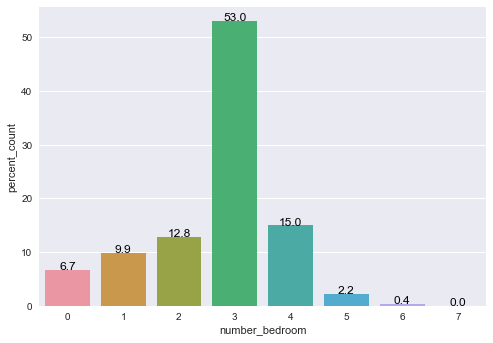

In [71]:
g = sns.barplot(x = 'number_bedroom', y = 'percent_count',data = df2)
g.set_ylabel('percent_count')
h = g.get_figure()
for index, row in df2.iterrows():
    g.text(row.number_bedroom,row.percent_count, round(row.percent_count,2), color='black', ha="center")
h.savefig('../data/excel/Percent_Count_NumBedroom_Condominium.png',bbox_inches = 'tight')

In [78]:
df.columns

Index(['Type', 'Location', 'Property', 'price', 'size', 'layout', 'furnishing',
       'bath', 'carpark', 'posting_date', 'Location_property', 'State',
       'num_bedroom', 'date', 'year', 'month', 'year_month', 'Price_persqft'],
      dtype='object')

In [100]:
#listing count by state
total_count = df.shape[0]
df2 = df.groupby('State')['Property'].count().reset_index()\
.rename(columns = {'Property':'Number_listings'})
df2['percent_count'] = round((df2['Number_listings']/total_count)*100,1)
df2.to_csv("../data/excel/Percent_Count_NumListings_ByState.csv",index = False, encoding = 'utf-8')

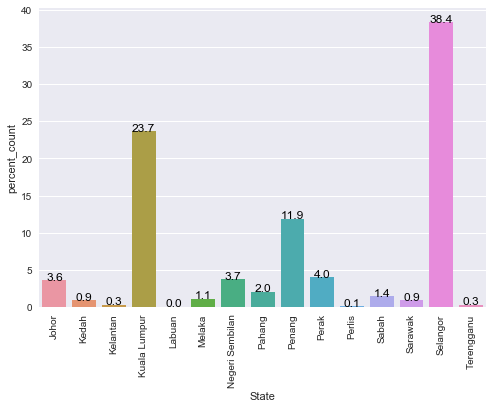

In [101]:
g = sns.barplot(x = 'State', y = 'percent_count',data = df2)
g.set_ylabel('percent_count')
h = g.get_figure()
for index, row in df2.iterrows():
    g.text(index,row.percent_count, round(row.percent_count,2), color='black', ha="center")
g.set_xticklabels(df2['State'],rotation = 90)
h.savefig('../data/excel/Percent_Count_NumListings_ByState.png',bbox_inches = 'tight')

In [6]:
df2 = df[remove_Outlier_box(df['size'])]
df2['size'].describe()

count   569,198.000
mean      1,146.043
std         375.131
min         230.000
25%         900.000
50%       1,100.000
75%       1,362.000
max       2,287.000
Name: size, dtype: float64

In [7]:
sizeCat_list = []
def getSizeCat(size):
    for i in size:
        if i<=500:
            sizeCat_list.append('200-500')
        elif i<=800:
            sizeCat_list.append('501-800')
        elif i<=1100:
            sizeCat_list.append('801-1100')
        elif i<=1400:
            sizeCat_list.append('1101-1400')
        elif i<=1700:
            sizeCat_list.append('1401-1700')
        else:
            sizeCat_list.append('more than 1701')
    return sizeCat_list
df2['Size_Category'] = getSizeCat(df2['size'])

df2 = df2.groupby(['Type','Size_Category'])['Property'].count().reset_index()\
.rename(columns = {'Property':'Number_listings'})
#df2['percent_count'] = round((df2['Number_listings']/total_count)*100,1)
#df2.to_csv("../data/excel/Percent_Count_NumListings_BySize.csv",index = False, encoding = 'utf-8')

sorterIndex = dict(zip(['200-500','501-800','801-1100',
                        '1101-1400','1401-1700','more than 1701'],
                       range(len(['200-500','501-800','801-1100',
                        '1101-1400','1401-1700','more than 1701']))))
df2['Size_Category2'] = df2['Size_Category'].map(sorterIndex)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
TotalCount_Dict = {'Condominium':sum(df2[df2['Type'] == 'Condominium']['Number_listings']),
                  'House':sum(df2[df2['Type'] == 'House']['Number_listings'])}
def CountPercent(HouseType,NumCount):
    Percent_list = []
    for i,j in enumerate(HouseType):
        Percent_list.append(round((NumCount[i]/TotalCount_Dict[j])*100,1))
    return Percent_list

df2['Percent_Count'] = CountPercent(df2['Type'],df2['Number_listings'])

In [29]:
df2[['Type','Size_Category','Size_Category2','Percent_Count']]\
.sort_values(['Type','Size_Category2'])\

Type   Size_Category  Size_Category2  Percent_Count
2   Condominium         200-500               0          2.800
3   Condominium         501-800               1         14.500
4   Condominium        801-1100               2         35.300
0   Condominium       1101-1400               3         26.500
1   Condominium       1401-1700               4         12.900
5   Condominium  more than 1701               5          8.000
8         House         200-500               0          1.000
9         House         501-800               1          6.100
10        House        801-1100               2         14.600
6         House       1101-1400               3         27.300
7         House       1401-1700               4         26.400
11        House  more than 1701               5         24.600

In [28]:
df2[['Type','Size_Category','Size_Category2','Percent_Count']]\
.sort_values(['Type','Size_Category2'])\
.to_excel('../data/excel/Percent_Count_NumListings_BySizeByHouse.xlsx')

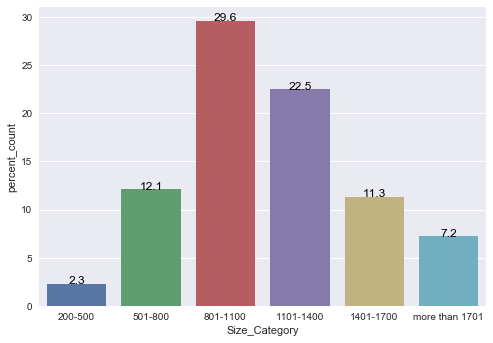

In [142]:
df_sorted = df2.sort_values('Size_Category2')
g = sns.barplot(x = 'Size_Category', y = 'percent_count',data = df_sorted)
g.set_ylabel('percent_count')
h = g.get_figure()
for index, row in df_sorted.iterrows():
    g.text(row.Size_Category2,row.percent_count, round(row.percent_count,2), color='black', ha="center")
#g.set_xticklabels(df2['Size_Category'],rotation = 90)
h.savefig('../data/excel/Percent_Count_NumListings_BySize.png',bbox_inches = 'tight')

In [194]:
df2.sort_values('Size_Category2').to_excel('../data/excel/NumberListings_BySizeByType.xlsx')

In [154]:
region_dict = {'Northern Region': ['Perlis', 'Kedah', 'Penang', 'Perak'],
'East Coast Region': ['Kelantan', 'Terengganu', 'Pahang'],
'Central Region': ['Selangor', 'Kuala Lumpur'],
'Southern Region': ['Negeri Sembilan', 'Melaka', 'Johor'],
              'East Malaysia':['Sabah','Sarawak','Labuan']}

df['Region'] = df['State'].map(lambda x: ''.join([i if x in j else '' for i,j in region_dict.items()]))

df2 = df.groupby('Region')['Property'].count().reset_index()\
.rename(columns = {'Property':'Number_listings'})
df2['percent_count'] = round((df2['Number_listings']/total_count)*100,1)
df2.to_csv("../data/excel/Percent_Count_NumListings_ByRegion.csv",index = False, encoding = 'utf-8')

In [166]:
df2

Region  Number_listings  percent_count
0     Central Region           384977         62.100
1  East Coast Region            15952          2.600
2      East Malaysia            14768          2.400
3    Northern Region           104665         16.900
4    Southern Region            52267          8.400

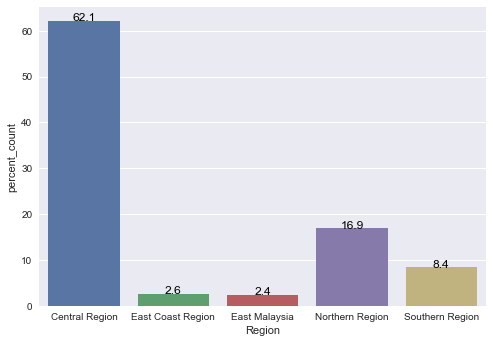

In [169]:
g = sns.barplot(x = 'Region', y = 'percent_count',data = df2)
g.set_ylabel('percent_count')
h = g.get_figure()
for index, row in df2.iterrows():
    g.text(index,row.percent_count, round(row.percent_count,2), color='black', ha="center")
#g.set_xticklabels(df2['Region'],rotation = 90)
h.savefig('../data/excel/Percent_Count_NumListings_ByRegion.png',bbox_inches = 'tight')